# Clean data

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

## Prepare raw data(responses)/key(dimension)/relationships

In [2]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = [i for i in os.listdir('input_data/') if i.startswith('CHN_triadic')][0]

# Prep responses and key
raw = pd.read_csv(os.getcwd()+'/input_data/'+qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])

# Prep responses and key
key = pd.read_csv('input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 39


In [3]:
# Prep relationships
filter_col = [col for col in raw if col.startswith('Q4.2')]
relationships = pd.read_csv('input_data/triadic_relationships_fix_label_sup.csv', index_col=0)
relationships = relationships.iloc[:,0].to_list()

# Prep dimensions
dimensions = key['dimension'].tolist()[1:-1]
items_to_remove = ["foil", "foil size"]
dimensions = [item for item in dimensions if item not in items_to_remove]

dimension_frames = {}
count = 1
for dim in dimensions:  # exclude foil and demographics
    # Special handling for specific dimensions
    if dim == "Morality":
        block_value = 35
    elif dim == "Trust":
        block_value = 36
    elif dim == "Generation Gap":
        block_value = 38
    else:
        block_value = key['block'].iloc[count]

    filtered_cols = [col for col in raw_reorg if col.startswith('Q' + str(block_value) + '.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])    
    count += 1
# Get total number of relationships and dimensions  
print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

Total number of relationships - 12
Total number of dimensions - 33


## time/foil/foil_size

In [4]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
time[time > time.mean() + 3.5 * time.std()]
outliers_max = time.index[time == time.max()]
time = time[~time.index.isin(outliers_max)]
outliers = time[time < time.mean() - 1.5 * time.std()]
outliers

Series([], Name: Duration (in seconds), dtype: int64)

In [5]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
print(time.max())
time_max_index = time.index[time == time.max()]
time = time[~time.index.isin(time_max_index)]
time = pd.DataFrame(time)

time['Random ID'] =raw_reorg['Random ID']
time = time.apply(pd.to_numeric)
time_melt = pd.melt(time, id_vars='Random ID')

outliers_time_list = list(time_max_index)
for col in time.columns[:-1]:
    outliers_time_list = outliers_time_list + list(time[time[col] < time[col].mean()-time[col].std()*1.5].index)
outliers_time_list = set(outliers_time_list)

outliers_time_list

2384


{19}

In [6]:
# Check foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q40.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [i.split(' - ', 1)[1] if ' - ' in i else i for i in foil_items]

filtered_cols = [col for col in raw_reorg if col.startswith('Q40.1')]
foils_size = pd.DataFrame(responses[filtered_cols])
foils_size.columns = foil_items
foils_size['Random ID'] =raw_reorg['Random ID']
foils_size = foils_size.apply(pd.to_numeric)

foils_size_melt = pd.melt(foils_size, id_vars='Random ID')

In [7]:
# Check for values above means for unexpected foils
outliers_size_list = []
for col in foils_size.columns[:-1]:
    outliers_size_list = outliers_size_list + list(foils_size[(foils_size[col] > foils_size[col].mean()+foils_size[col].std()*3.5) |
                   (foils_size[col] < foils_size[col].mean()-foils_size[col].std()*3.5)].index)
outliers_size_list = set(outliers_size_list)

In [8]:
# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_size_outliers = foils_size
foil_size_outliers = foil_size_outliers[~foil_size_outliers.index.isin(outliers_size_list)]
foil_size_outliers_melt = pd.melt(foil_size_outliers, id_vars='Random ID')
foil_size_outliers_melt.columns = ['Random ID','variable','value']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


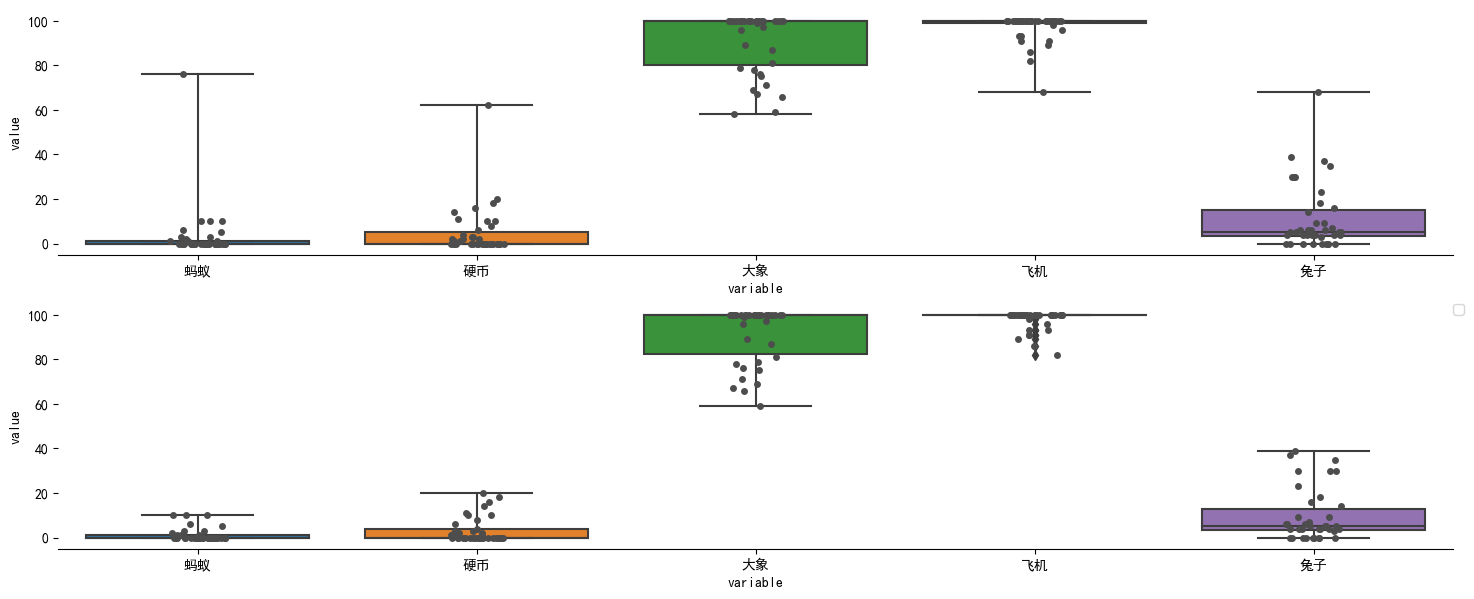

In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei']
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [10]:
# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q39')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q39.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_items = [i.split(' - ', 1)[1] for i in foil_items if ' - ' in i]
filtered_cols = [col for col in raw_reorg if col.startswith('Q39.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['Random ID']  =raw_reorg['Random ID']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='Random ID')

In [11]:
# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*3.5) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*3.5)].index)
outliers_list = set(outliers_list)

In [12]:
# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='Random ID')
foil_outliers_melt.columns = ['Random ID','variable','value']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


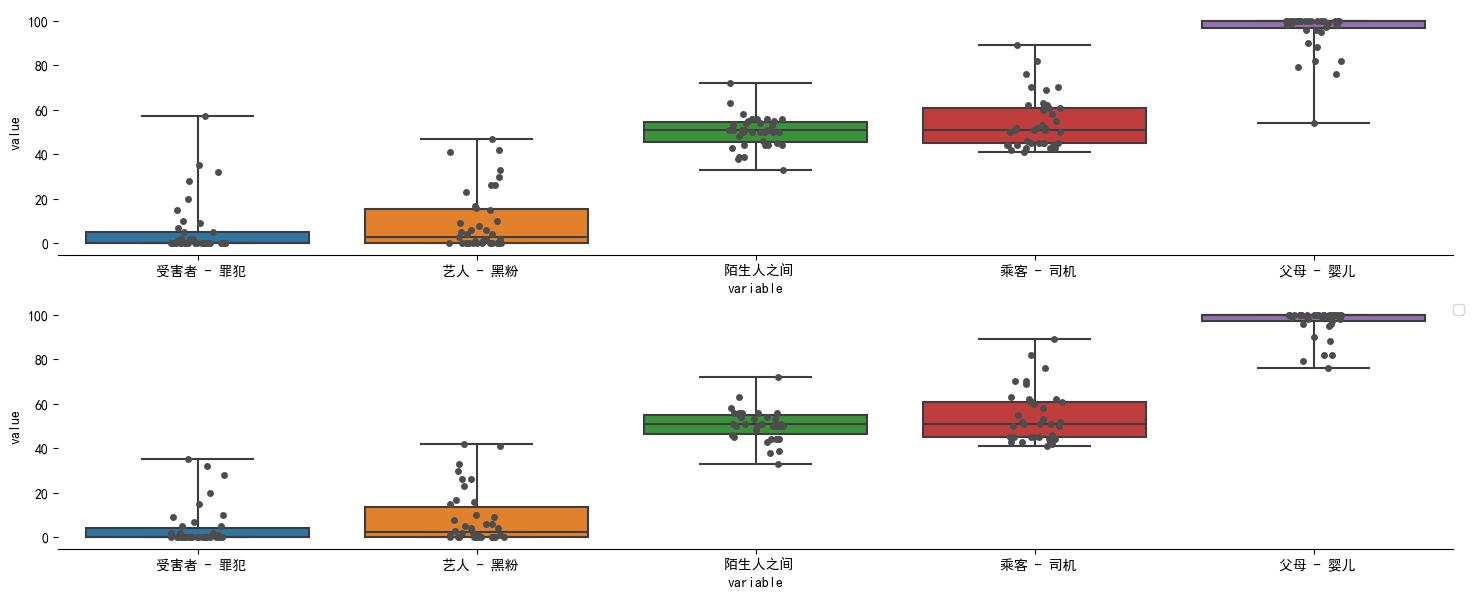

In [13]:
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
foils_melt['variable'] = [i.split('程度 -')[1] for i in foils_melt['variable']]
foil_outliers_melt['variable'] = [i.split('程度 -')[1] for i in foil_outliers_melt['variable']]
sns.stripplot(x="variable", y="value", data=foils_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [14]:
# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['Random ID'] = raw_reorg['Random ID']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='Random ID')

In [15]:
# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

In [16]:
# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_size_list) + list(familiarity_list)+list(outliers_time_list))
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    temp_df = dimension_frames_outliers[dim].count()
    temp_df.index = relationships
    num_response_outliers[dim] = temp_df

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Total number of responses, excluding bad participants - 37
Smallest number of ratings for a relationship - 7
Largest number of ratings for a relationship - 12


In [18]:
result_dict = dimension_frames_outliers
with pd.ExcelWriter('output_data/dict_results/CHN_triadic_sup.xlsx')as writer:
    for dim in result_dict.keys():
        temp_df = result_dict[dim]
        temp_df.columns = relationships
        temp_df.to_excel(writer, sheet_name = dim)

## Demographics

In [19]:
filtered_demo = [col for col in raw_reorg if col.startswith('Q41')]
response_demographic = raw_reorg.loc[:,filtered_demo]
response_demographic = response_demographic[~response_demographic.index.isin(outliers_all_list)]
response_demographic.columns = ['Age','Gender','Race','Ethnicity',
                                'Highest education','First language','First language alternative']
response_demographic.head()

,Age,Gender,Race,Ethnicity,Highest education,First language,First language alternative
0,18 - 24,女,汉族,NaN,大学本科,是,NaN
1,18 - 24,女,汉族,NaN,大学本科,是,NaN
2,18 - 24,男,汉族,NaN,大学本科,是,NaN
3,18 - 24,女,汉族,NaN,大学本科,是,NaN
4,18 - 24,女,汉族,NaN,大学本科,是,NaN


### Gender

In [20]:
response_demographic['Gender'][response_demographic['Gender'].isna()] = 'No response'
response_demographic['Gender'].value_counts()

女    20
男    17
Name: Gender, dtype: int64

### Age

In [21]:
response_demographic['Age'][response_demographic['Age'].isna()] = 'No response'
response_demographic['Age'].value_counts()

18 - 24    21
25 - 34    14
35 - 44     2
Name: Age, dtype: int64

### Race

In [22]:
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'].value_counts()

汉族    37
Name: Race, dtype: int64

### Highest education

In [23]:
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'].value_counts()

大学本科    31
硕士       3
大专       2
高中       1
Name: Highest education, dtype: int64

### First language

In [24]:
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'].value_counts()

是    37
Name: First language, dtype: int64

## Heatmap

<AxesSubplot: >

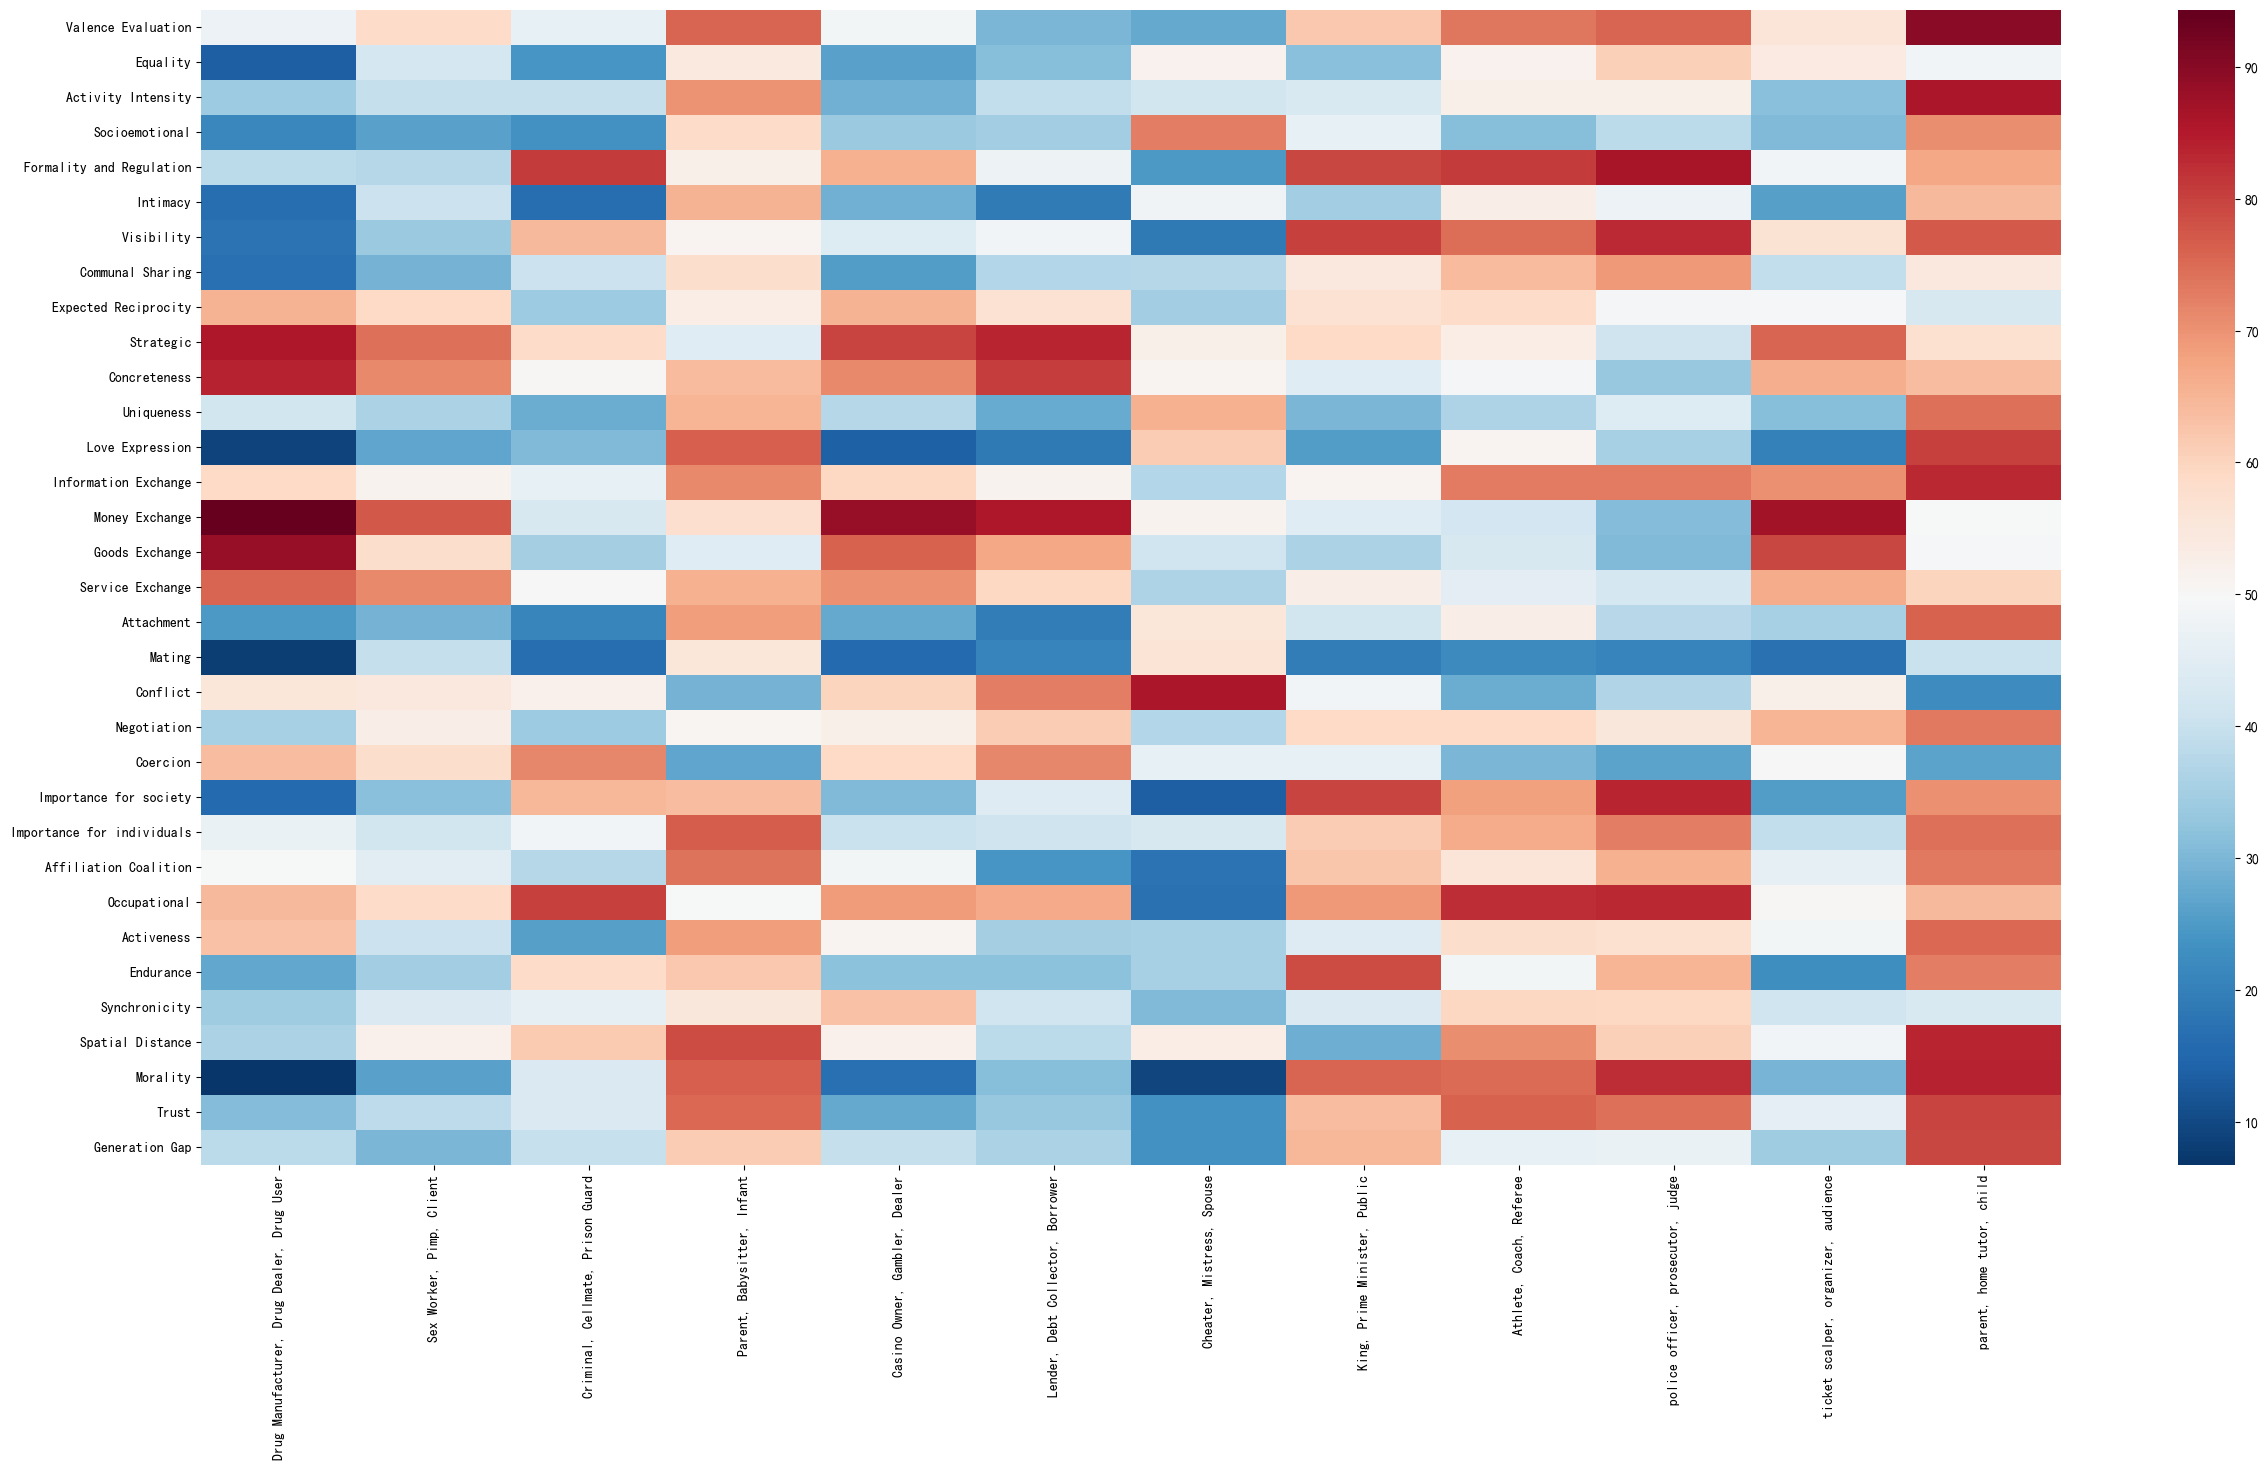

In [25]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions:
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions
dim_rel.to_csv('output_data/cleaning_results/chn_triadic_dim_rel_33d_sup.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

(33, 34)

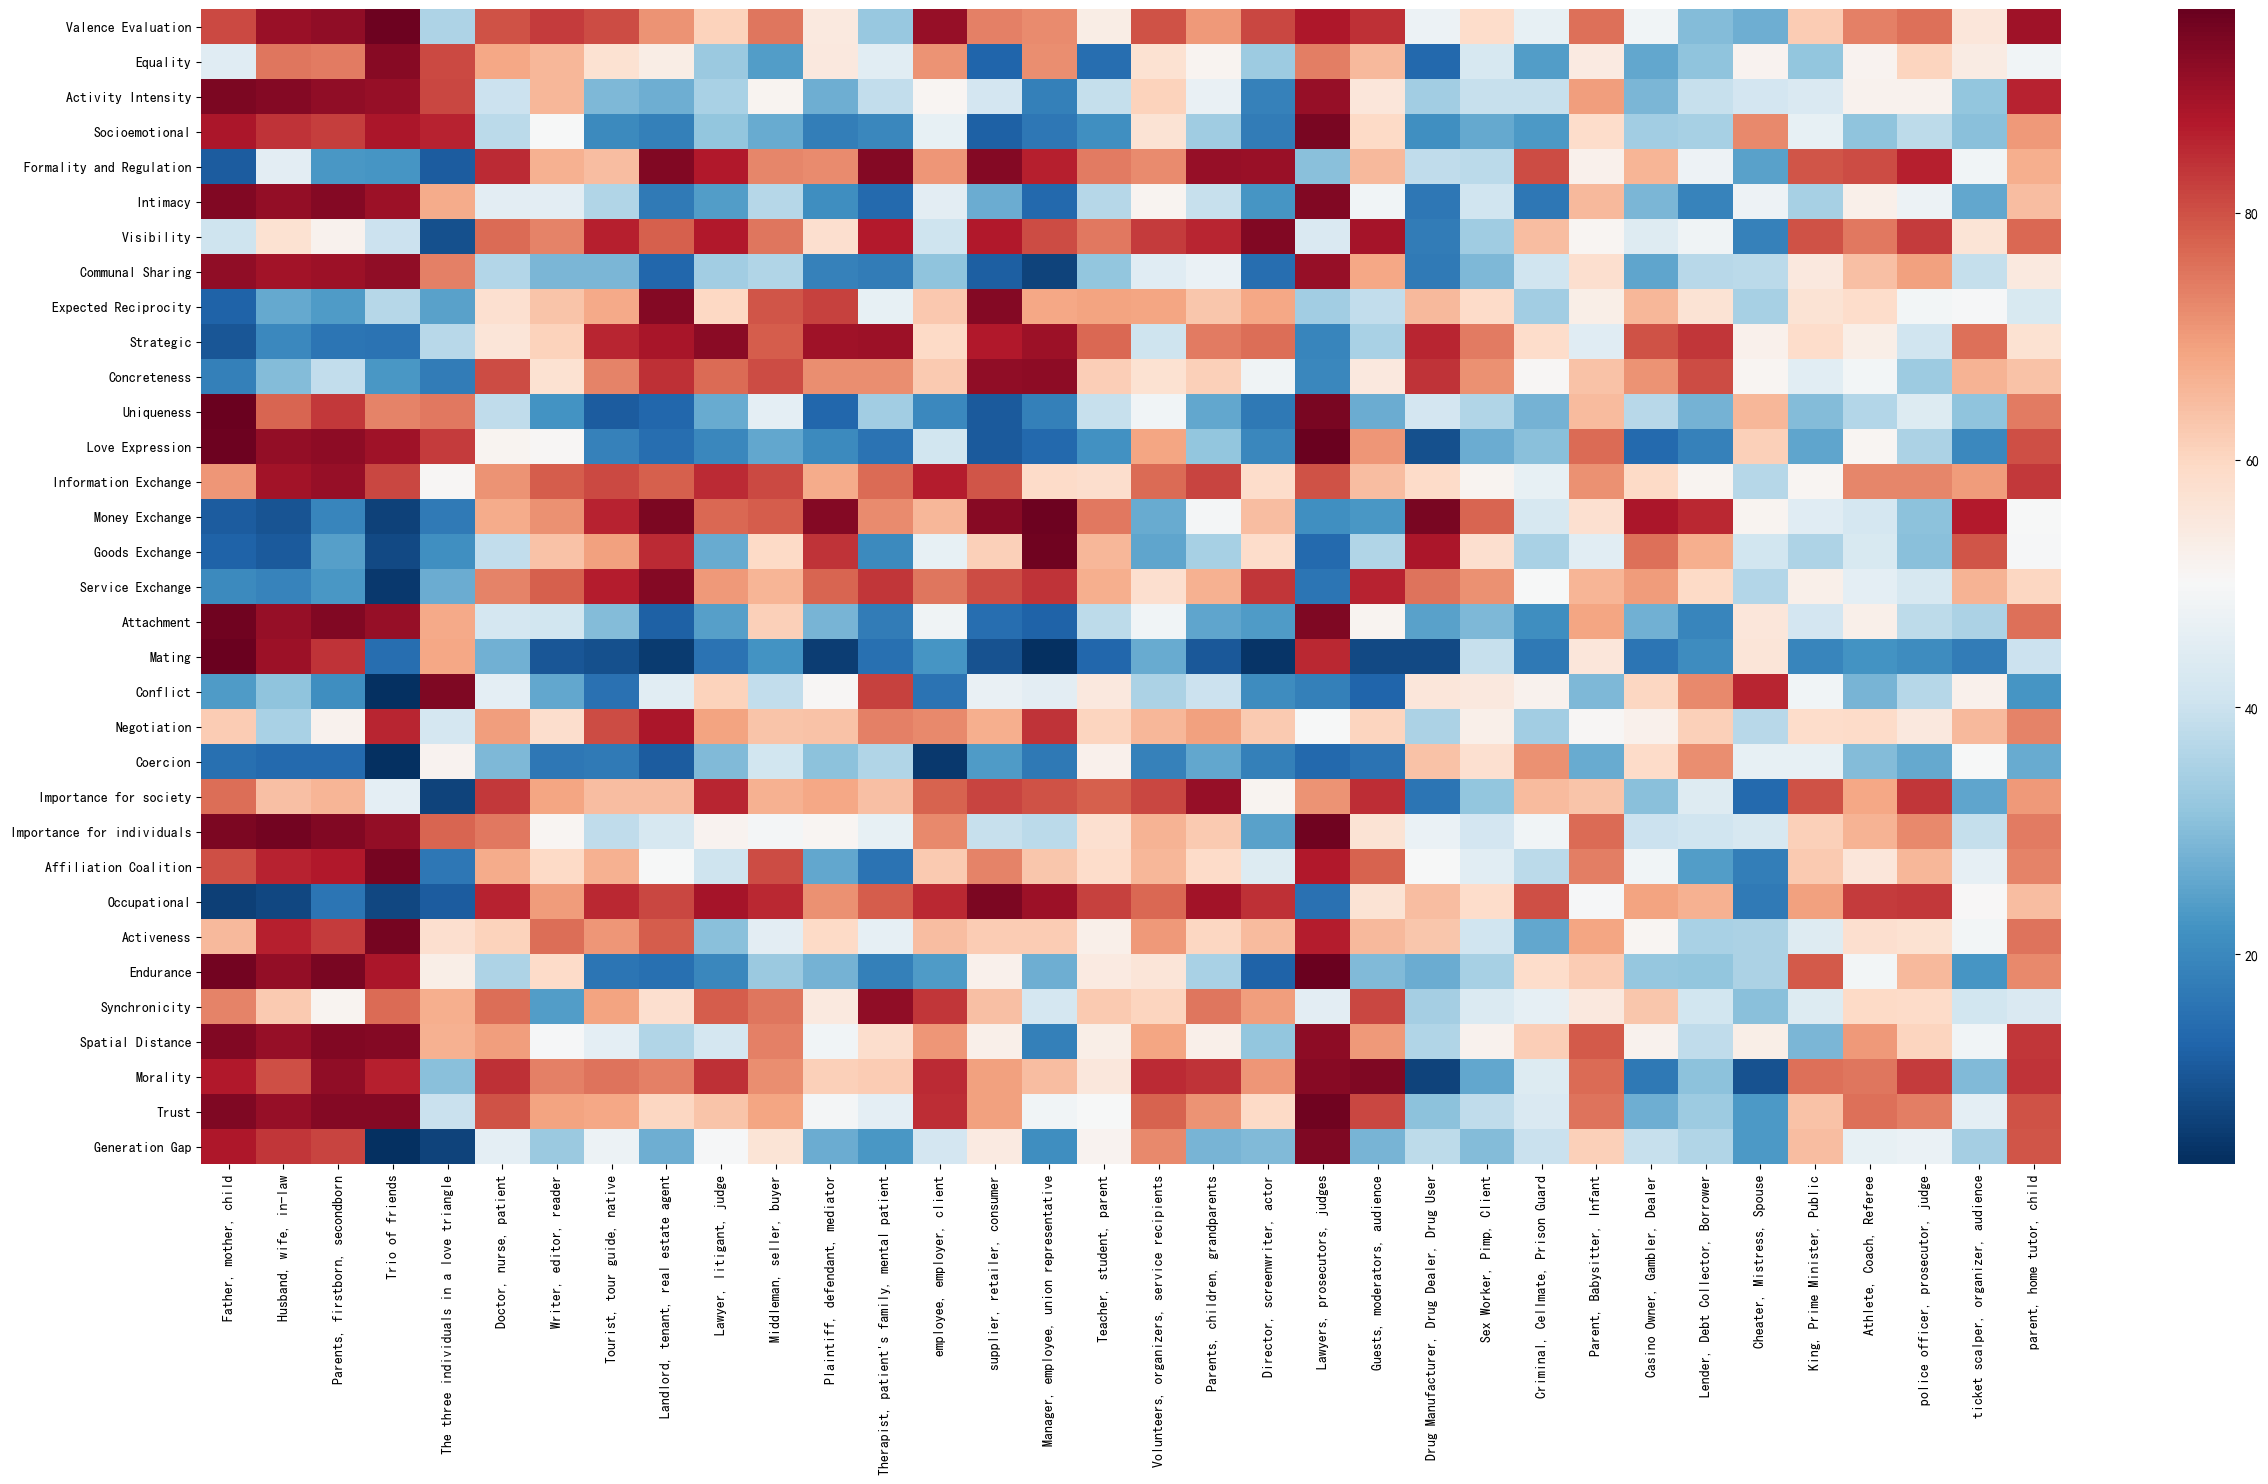

In [26]:
# Reload the CHN_dim_rel_scaled.csv file
sup_data = pd.read_csv("output_data/cleaning_results/chn_triadic_dim_rel_33d_sup.csv", index_col=0)
# Load the group_dim_rel_scaled_33d.csv file
triadic_data = pd.read_csv("output_data/cleaning_results/chn_triadic_dim_rel_33d.csv", index_col=0)

# Concatenate the two dataframes
merged_data = pd.concat([triadic_data, sup_data],axis = 1)
plt.figure(figsize=(30,15))
sns.heatmap(merged_data, center=50,cmap="RdBu_r")
# Save the merged dataframe to a new csv file
merged_data.to_csv("output_data/cleaning_results/chn_triadic_dim_rel_33d_all.csv", index=True)

merged_data.shape

In [27]:
dim_rel_scaled = preprocessing.scale(merged_data.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=merged_data.columns,columns=merged_data.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/chn_triadic_dim_rel_scaled_33d_all.csv')

# PCA

In [2]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)

library(ggplot2)
library(corrplot)
library(RColorBrewer)

library(tidyverse)
library(reshape)#melt
library(nFactors)#optimal number of components

## optimal dimensions
plotnScree:https://rdrr.io/cran/nFactors/src/R/plotnScree.R

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
   }

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/cleaning_results/chn_triadic_dim_rel_scaled_33d_all.csv', row.names=1,encoding='UTF-8')
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, model = "components",aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05 

In [5]:
nS$Analysis$Cumu[1:5]

[1] 0.5335601 0.7484194 0.8067382 0.8600217 0.8901074

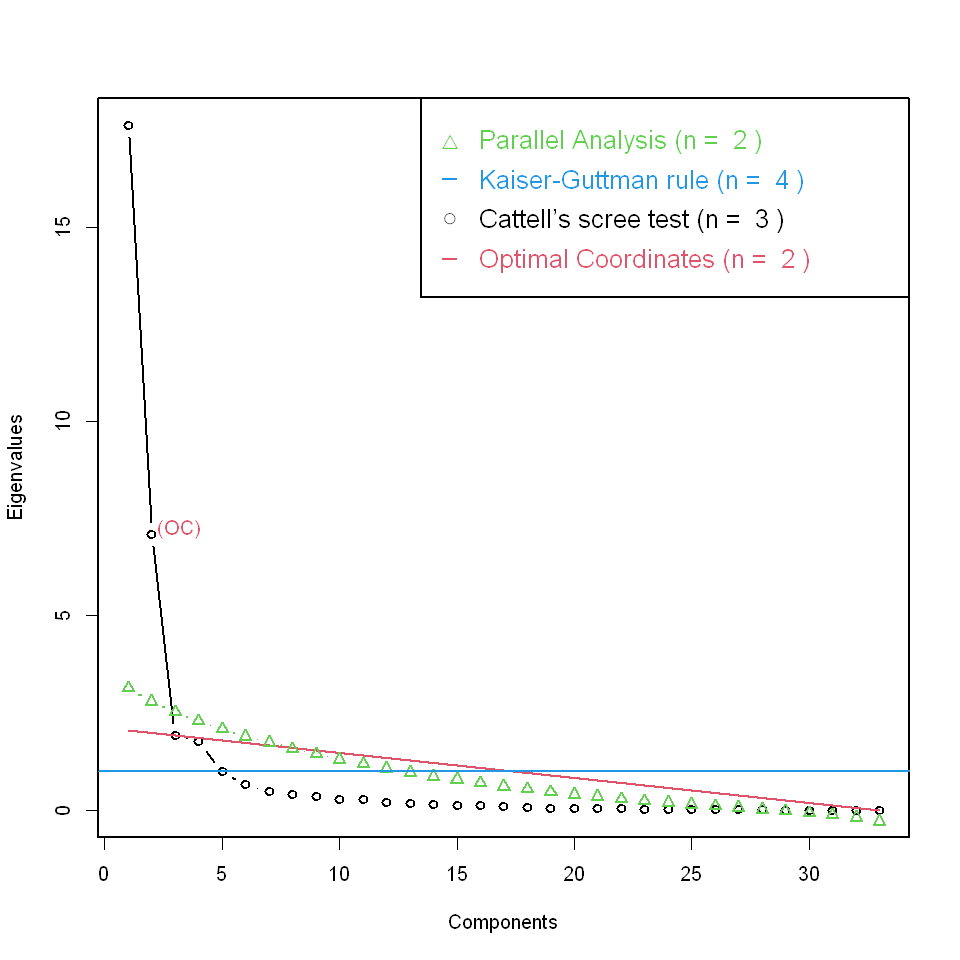

In [6]:
options(repr.plot.width=8,repr.plot.height=8)
plotnScree(nS, elbow = 3,legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## loading score

In [8]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/chn_triadic_loadings_var_all_5c.csv')
write.csv(scores_var,'output_data/pca_results/chn_triadic_scores_var_all_5c.csv')


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.196  0.944  0.166              
Equality                   -0.485  0.511 -0.196 -0.543  0.113
Activity.Intensity         -0.861  0.370 -0.168  0.193       
Socioemotional             -0.910  0.237 -0.258              
Formality.and.Regulation    0.667         0.679         0.159
Intimacy                   -0.865  0.440 -0.202  0.133       
Visibility                  0.417  0.325  0.771         0.155
Communal.Sharing           -0.940  0.247                     
Expected.Reciprocity        0.906  0.132                     
Strategic                   0.937 -0.315                     
Concreteness                0.922                0.182       
Uniqueness                 -0.869        -0.334  0.269       
Love.Expression            -0.892  0.360 -0.161              
Information.Exchange               0.764         0.255  0.455
Money.Exchange              0.954 -0.182 -0.188  0.109     

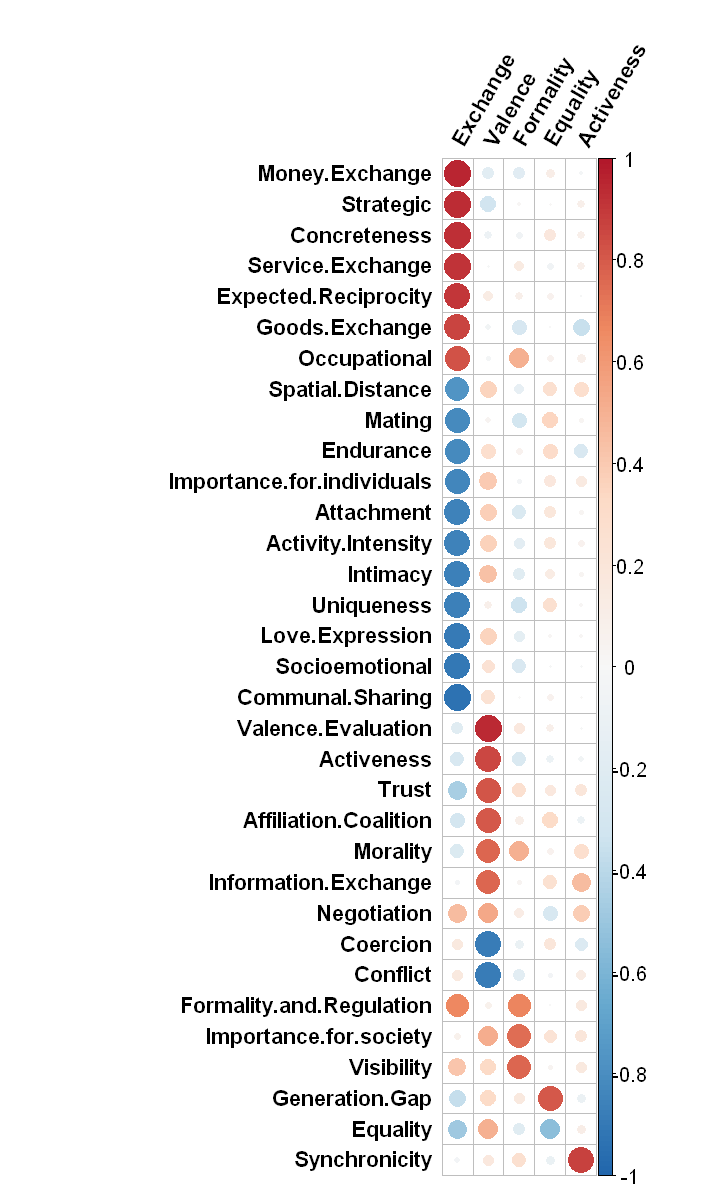

In [9]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Exchange','Valence','Formality','Equality','Activeness')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Exchange))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Valence))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(Formality)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Equality))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Activeness))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## relationship score

In [11]:
library(ggrepel)
scores_var_plot = data.frame(scores_var)
colnames(scores_var_plot) = c('Exchange','Valence','Formality','Equality','Activeness')
scores_var_plot['Equality'] = -scores_var_plot['Equality']
scores_var_plot['Activeness'] = -scores_var_plot['Activeness']

scores_var_plot['rel'] = rownames(scores_var_plot)

In [12]:
Plot_scatter = 
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.title=element_text(size=28,face='bold'),
      axis.text=element_text(size=28,face='bold'))

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


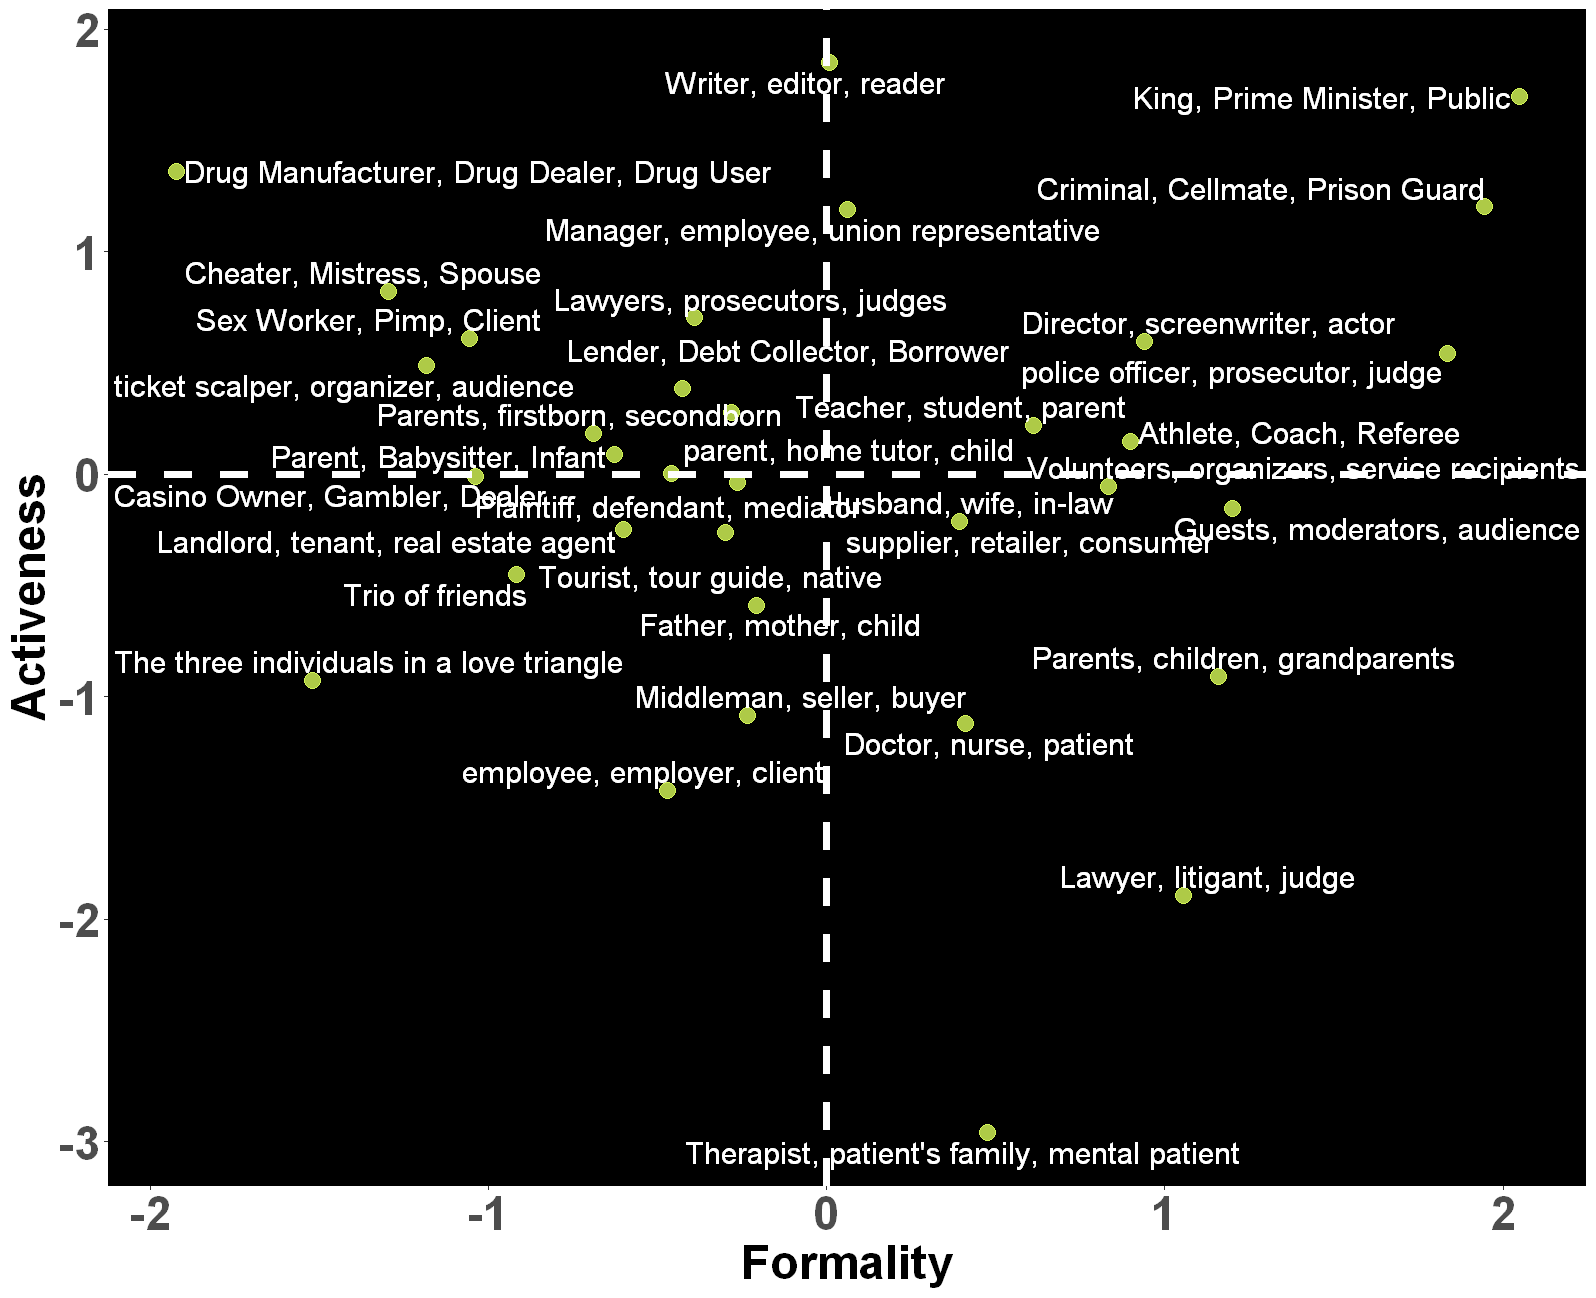

Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


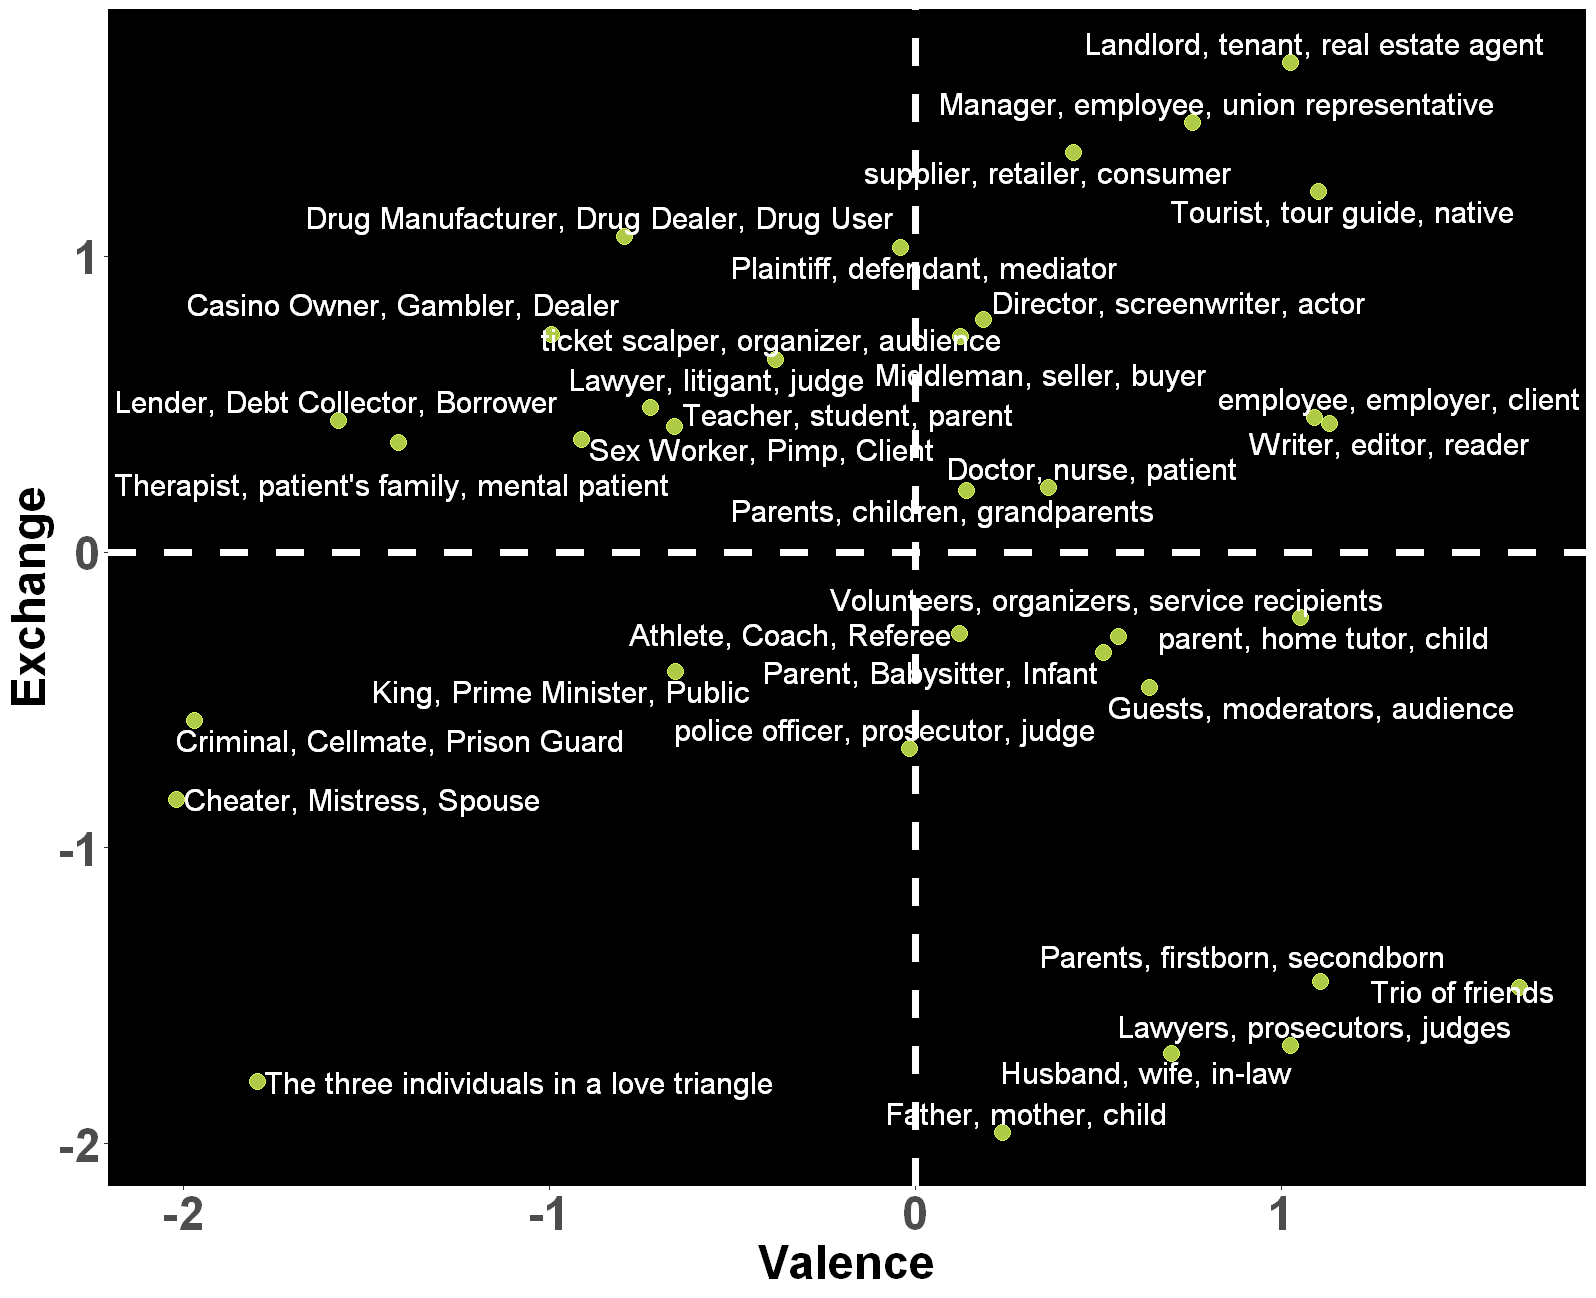

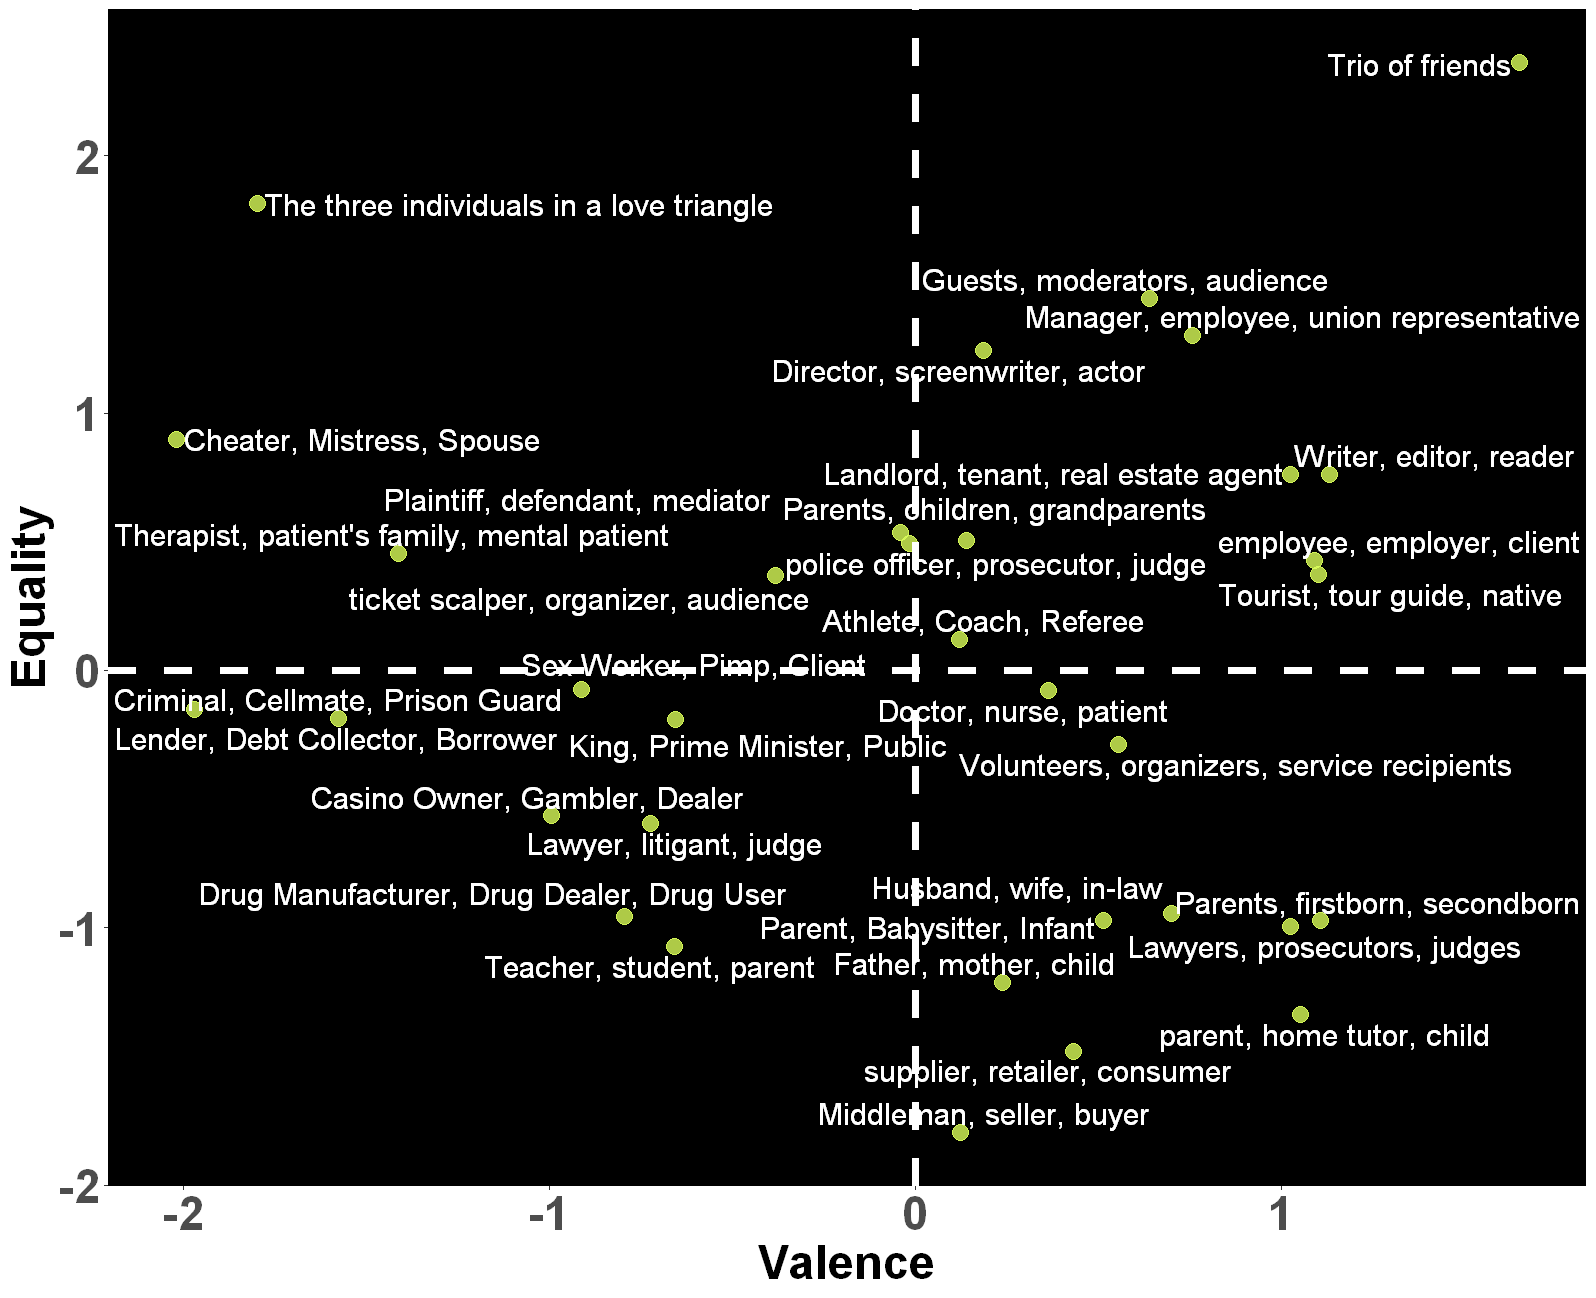

In [13]:
randomseed = 2022
options(repr.plot.height=10.82,repr.plot.width=13.3)
ggplot(scores_var_plot, aes(x=Formality,y=Activeness))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter


ggplot(scores_var_plot, aes(x=Valence,y=Exchange))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter


ggplot(scores_var_plot, aes(x=Valence,y=Equality))+
geom_point(color='#DAFD59',alpha=0.8,size=4.5)+
geom_text_repel(aes(label=rel),size=6.5,
                seed = randomseed,,color='white',
                min.segment.length = Inf)+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
Plot_scatter

## other models

### 2 dimensions

In [14]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 2

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/chn_triadic_loadings_var_all_2c.csv')
write.csv(scores_var,'output_data/pca_results/chn_triadic_scores_var_all_2c.csv')

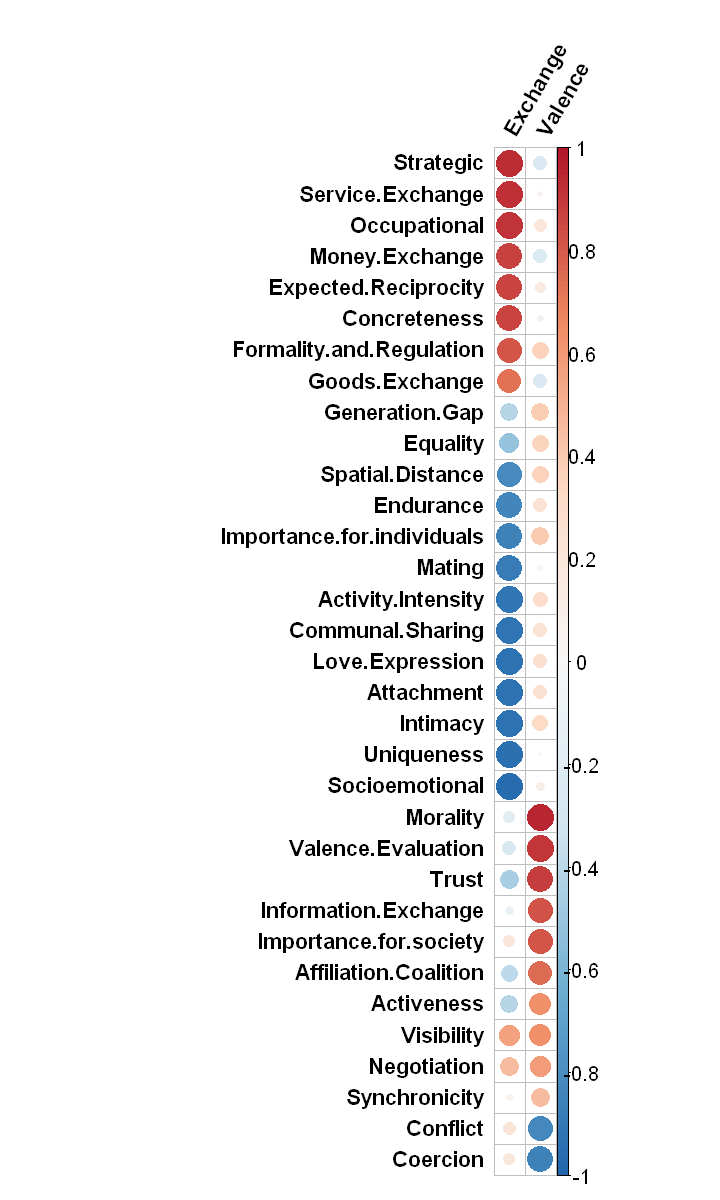

In [15]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))

loadings_var_reorder = rbind(RC1,RC2)
loadings_var_reorder = loadings_var_reorder[1:2]
colnames(loadings_var_reorder) = c('Exchange','Valence')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 1.2,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

### 3 dimensions

In [16]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 3

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/chn_triadic_loadings_var_all_3c.csv')
write.csv(scores_var,'output_data/pca_results/chn_triadic_scores_var_all_3c.csv')

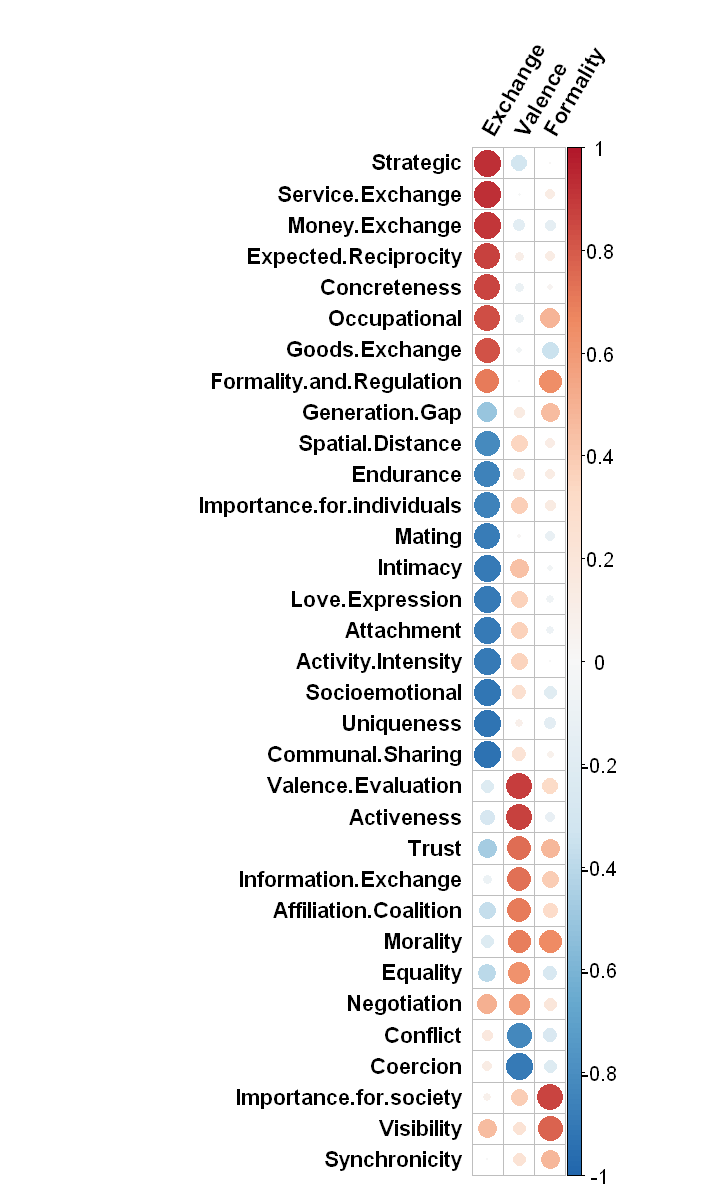

In [17]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:3)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))

loadings_var_reorder = rbind(RC1,RC2,RC3)
loadings_var_reorder = loadings_var_reorder[1:3]
colnames(loadings_var_reorder) = c('Exchange','Valence','Formality')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.8,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

### 4 dimensions

In [18]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 4

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/chn_triadic_loadings_var_all_4c.csv')
write.csv(scores_var,'output_data/pca_results/chn_triadic_scores_var_all_4c.csv')

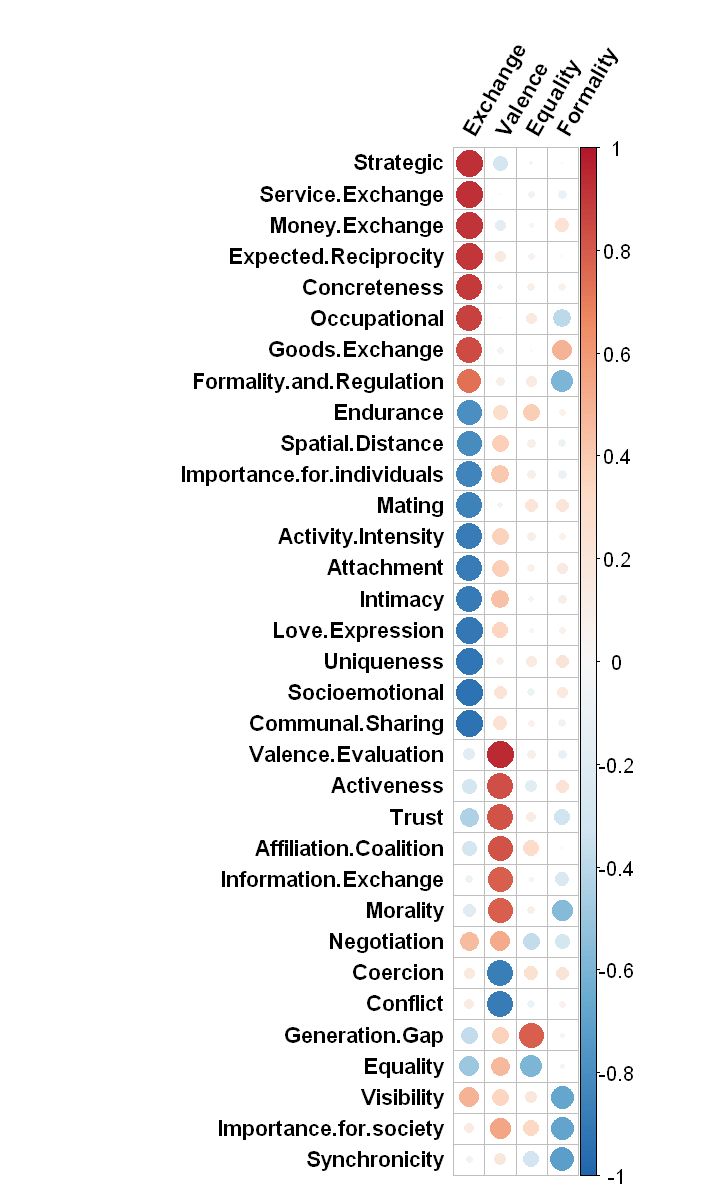

In [19]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]
colnames(loadings_var_reorder) = c('Exchange','Valence','Equality','Formality')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.6,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

### 6 dimensions

In [20]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 6

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

write.csv(loadings_var,'output_data/pca_results/chn_triadic_loadings_var_all_6c.csv')
write.csv(scores_var,'output_data/pca_results/chn_triadic_scores_var_all_6c.csv')

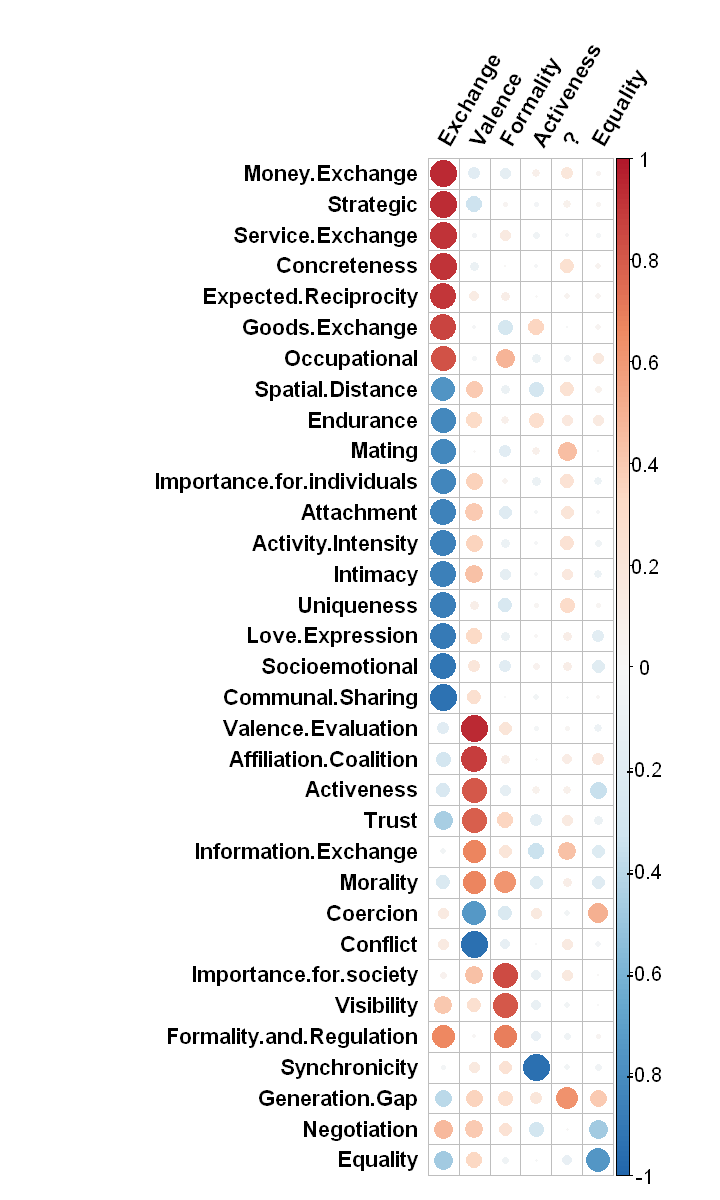

In [21]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]
colnames(loadings_var_reorder) = c('Exchange','Valence','Formality','Activeness','?','Equality')

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.3,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))